In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score,accuracy_score,r2_score
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer 
from sklearn.compose import make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
med = pd.read_csv('insurance.csv')

In [4]:
X = med.drop('charges',axis=1)
y = med['charges']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=24, test_size=0.3)

In [7]:
med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [9]:

ohe = OneHotEncoder(sparse_output=False,handle_unknown='ignore').set_output(transform='pandas')
ct = make_column_transformer(('passthrough', make_column_selector(dtype_exclude=object)  ),
                             (ohe,make_column_selector(dtype_include=object)  ),
                             verbose_feature_names_out=False).set_output(transform='pandas')


In [10]:
dtr = DecisionTreeRegressor(random_state=24)
pipe  = Pipeline([('CT',ct),('DT',dtr)])
kfold = KFold(n_splits=5,shuffle=True,random_state=24)
params = {'DT__min_samples_split':[2,10,25,50], 'DT__min_samples_leaf':[1,10,25,50],'DT__max_depth':[None,4,6]}
gcv = GridSearchCV(pipe,param_grid=params,cv=kfold,scoring='r2',verbose=3)
gcv.fit(X,y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2;, score=0.782 total time=   0.0s
[CV 2/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2;, score=0.698 total time=   0.0s
[CV 3/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2;, score=0.750 total time=   0.0s
[CV 4/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2;, score=0.725 total time=   0.0s
[CV 5/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2;, score=0.707 total time=   0.0s
[CV 1/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=10;, score=0.836 total time=   0.0s
[CV 2/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=10;, score=0.761 total time=   0.0s
[CV 3/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=10;, score=0.783 total time=   0.0s
[CV 4/5] END DT__max_de

GridSearchCV(cv=KFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000016A0BEB0410>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000016A0BEB17C0>)],
                                                          verbose_feature_names_out=False)),
                                       ('DT',
                                        DecisionTreeRegressor(random_state=24))]),
             param_grid={'DT__max_depth': [None, 4, 6],
                         'DT__min_samples_leaf': [1, 10, 25, 50],
                         'DT__min_samples_split': [2, 10, 25, 50]},
             scoring='r2', verbose=3)

In [11]:
print(gcv.best_params_)
print(gcv.best_score_)

{'DT__max_depth': 6, 'DT__min_samples_leaf': 50, 'DT__min_samples_split': 2}
0.8519043198478518


In [13]:
best_tree = gcv.best_estimator_.named_steps['DT']
best_tree

DecisionTreeRegressor(max_depth=6, min_samples_leaf=50, random_state=24)

In [14]:
best_tree.feature_importances_

array([0.10879376, 0.16672587, 0.00757747, 0.        , 0.        ,
       0.71524286, 0.        , 0.00166003, 0.        , 0.        ,
       0.        ])

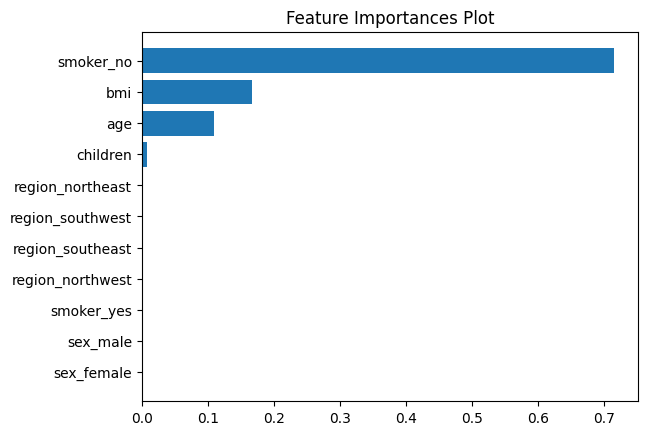

In [16]:
df_imp= pd.DataFrame({'feature':gcv.best_estimator_.named_steps['CT'].get_feature_names_out() ,
               'importance':best_tree.feature_importances_})
df_imp.sort_values('importance', inplace=True)
plt.barh(df_imp['feature'], df_imp['importance'])
plt.title("Feature Importances Plot")
plt.show()